In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pymoo.algorithms.nsga2 import NSGA2
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination
from pymoo.util.misc import stack

from escribe_input import corre_phits_single

Se va a resolver un problema de optimización de blindaje consistente en tres capas de materiales:

haz fotones -> | d1 (n1) | d2 (n2) | d3 (n3) | detector 

* d1, d2, d3 son las tres variables continuas que representan el espesor de cada capa
* n1, n2, n3 son las tres variables discretas que representan a los materiales de cada capa
* Dentro de la función `corre_phits_single` se encuentra un diccionario que mapea estas variables discretas en los materiales que serán escritos en el archivo de entrada de PHITS

In [2]:
!rm -fr runs

In [10]:
!cat input_master

$OMP=4
[ T i t l e ]
Input file for shieldin optimization

[ P a r a m e t e r s ]
 icntl    =           0     # (D=0) 3:ECH 5:NOR 6:SRC 7,8:GSH 11:DSH 12:DUMP
 maxcas   =        1000     # (D=10) number of particles per one batch
 maxbch   =         100     # (D=10) number of batches
 emin(6)  =    1.00E-03     # (D=1.0) cut-off energy of muon+ (MeV)
 emin(7)  =    1.00E-03     # (D=1.0) cut-off energy of muon- (MeV)
 negs     =           1     # (D=0) =1 EGS photon and electron
 ipnint   =           0     # (D=0) 0: no, 1: consider photo-nuclear reaction

[ S o u r c e ]
  totfact =   1
   s-type =   1
     proj =   photon        # kind of incident particle
       r0 =   1.0           # radius [cm]
       x0 =   0.0000        # (D=0.0) center position of x-axis [cm]
       y0 =   0.0000        # (D=0.0) center position of y-axis [cm]
       z0 =  -1.000E-4      # minimum position of z-axis [cm]
       z1 =  -1.000E-4      # maximum position of z-axis [cm]
      dir =   1.0000
   e-ty

In [3]:
class MyProblem_dis(Problem):

    def __init__(self):
        super().__init__(n_var=6,
                         n_obj=2,
                         n_constr=1,
                         xl=np.array(3*[0] + 3*[1]),
                         xu=np.array(3*[5] + 3*[5]))

    def _evaluate(self, X, out, *args, **kwargs):
        f1 = []
        for x in X:
            f1.append(corre_phits_single(x))
        f1 = np.asarray(f1)
        f2 = X[:, 0] + X[:, 1] + X[:, 2]

        g1 = X[:, 0] + X[:, 1] + X[:, 2] - 15.0

        out["F"] = np.column_stack([f1, f2]).astype(np.float)
        out["G"] = g1
        
mask = 3*["real"] + 3*["int"]

from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover

sampling = MixedVariableSampling(mask, {
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random")
})

crossover = MixedVariableCrossover(mask, {
    "real": get_crossover("real_sbx", prob=0.9, eta=3.0),
    "int": get_crossover("int_sbx", prob=0.9, eta=3.0)
})

mutation = MixedVariableMutation(mask, {
    "real": get_mutation("real_pm", eta=3.0),
    "int": get_mutation("int_pm", eta=3.0)
})

In [4]:
problem_dis = MyProblem_dis()

algorithm_dis = NSGA2(
    pop_size=100,
    n_offsprings=20,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True,
)

termination = get_termination("n_gen", 40)

res = minimize(problem_dis,
               algorithm_dis,
               termination,
               seed=1,
               save_history=True,
               verbose=True
               )

# get the pareto-set and pareto-front for plotting
ps = problem_dis.pareto_set(use_cache=False, flatten=False)
pf = problem_dis.pareto_front(use_cache=False, flatten=False)


n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 | -0.00000E+00 | -0.00000E+00 |      13 |            - |            -
    2 |     120 | -0.00000E+00 | -0.00000E+00 |      14 |  0.008419253 |            f
    3 |     140 | -0.00000E+00 | -0.00000E+00 |      15 |  0.015760290 |            f
    4 |     160 | -0.00000E+00 | -0.00000E+00 |      18 |  0.005210949 |            f
    5 |     180 | -0.00000E+00 | -0.00000E+00 |      17 |  0.008269173 |            f
    6 |     200 | -0.00000E+00 | -0.00000E+00 |      21 |  0.013290583 |            f
    7 |     220 | -0.00000E+00 | -0.00000E+00 |      23 |  0.027059739 |        nadir
    8 |     240 | -0.00000E+00 | -0.00000E+00 |      22 |  0.004517091 |            f
    9 |     260 | -0.00000E+00 | -0.00000E+00 |      25 |  0.004332375 |            f
   10 |     280 | -0.00000E+00 | -0.00000E+00 |      27 |  0.125969150 |        nadir
   11 |     300 | -0.00000E+00 | -0.00000E+00 |      2

In [5]:
res.X[:, 3:6]

array([[1, 1, 1],
       [1, 5, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 4],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 3],
       [1, 1, 1],
       [1, 1, 4],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 3],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 5, 1],
       [1, 1, 5],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 4],
       [1, 1, 1],
       [1, 5, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [3, 1, 1],
       [1, 1, 4],
       [1, 1, 1],
       [1, 1, 1],
       [1, 5, 1],
       [1, 2, 1],
       [1, 1, 1],
       [1, 1, 4],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 5],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 5],
       [1, 5, 1],
       [1, 1, 1],
       [1, 2, 1],
       [1, 2, 1],
       [1, 1, 5],
       [1,

<IPython.core.display.Javascript object>


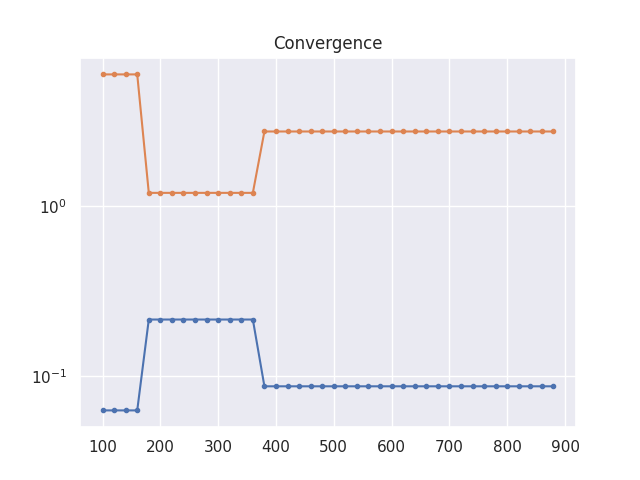

In [6]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])


plt.title("Convergence")
plt.plot(n_evals, opt, ".-")
plt.yscale("log")
plt.show()

<IPython.core.display.Javascript object>


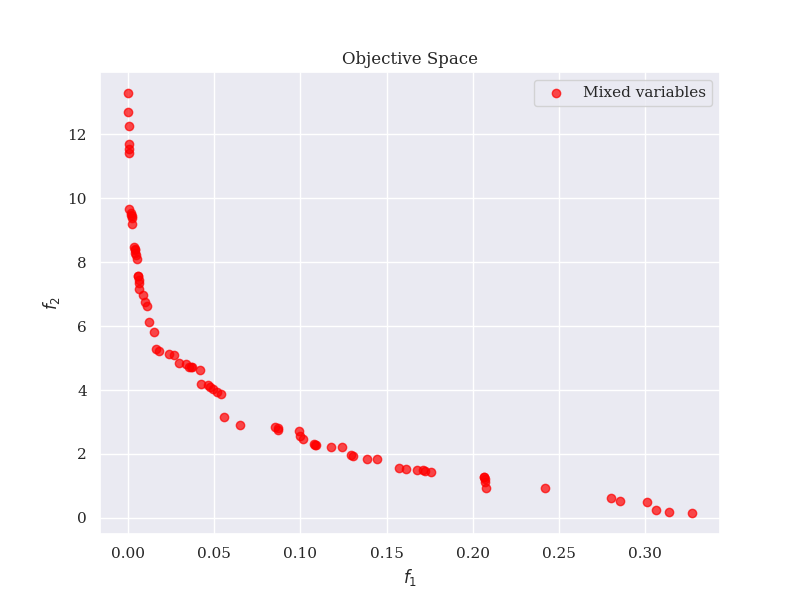

In [7]:
# Design Space
#plot = Scatter(title = "Design Space", axis_labels="x")
#plot.add(res.X, s=30, facecolors='none', edgecolors='r', label='Mixed variables')
#plot.do()
#plot.apply(lambda ax: ax.set_xlim(-0.5, 1.5))
#plot.apply(lambda ax: ax.set_ylim(-2, 2))
#plot.apply(lambda plt: plt.legend())
#plot.show()

# Objective Space
plot_ob = Scatter(title = "Objective Space")
plot_ob.add(res.F, color='red', alpha=0.7, label='Mixed variables')
plot_ob.do()
plot_ob.apply(lambda plt: plt.legend())
#plot_ob.apply(lambda ax: ax.set_xscale('log'))
plot_ob.show();

In [8]:
b = np.column_stack((res.F, res.X))
b[b[:, 0].argsort()]

array([[0.0002009, 13.286642886243316, 4.149847852086103,
        4.805084206961579, 4.331710827195634, 1, 1, 1],
       [0.00026098, 12.707415655174252, 4.014459477988045,
        4.693479652947389, 3.999476524238818, 1, 1, 1],
       [0.00039044, 12.251338067762397, 3.403568942779139,
        4.2741928239731815, 4.5735763010100765, 1, 1, 1],
       [0.00053962, 11.698771301183388, 4.014459477988045,
        3.6848352989565245, 3.999476524238818, 1, 1, 1],
       [0.00072267, 11.53314327789479, 4.477926971751447,
        2.7403963218003833, 4.314819984342961, 1, 1, 1],
       [0.00078167, 11.425098833165542, 4.014459477988045,
        2.7493174266351943, 4.661321928542302, 1, 1, 1],
       [0.00082101, 9.656734426603181, 0.6315439464601593,
        4.693479652947389, 4.331710827195634, 1, 1, 1],
       [0.0019054, 9.53182596992741, 4.014459477988045,
        4.0497877867591585, 1.4675787051802063, 1, 1, 1],
       [0.0020922, 9.471825803351603, 4.726079705797922,
        4.16395382717

In [ ]:
a=res.F
a[a[:,0].argsort()]

In [ ]:
aa

In [ ]:
for a in aa:
    print(a)